# An Example to Set the Stage

Before we start, here are some boring preliminaries to load the code to execute this notebook into your environment.

In [ ]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

In [1]:
using Astrostatistics688 # Loads some code specific to this course with utility functions, etc
using DataFrames
using LaTeXStrings
using Logging
using Printf
using StatsBase
using StatsPlots
using Turing

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342
┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1342


## It Was a Dark and Stormy Night...

...in the middle of the COVID 19 pandemic.  You are facing an unpleasant task (writing a grant proposal, cleaning the kitchen, etc) when your colleague [Jeff Kissell](https://scholar.google.com/citations?user=IrkY3dQAAAAJ&hl=en) emails you, asking for advice with the analysis of some measurements.  Jeff and his collaborators have been pushing on the LIGO mirrors gravitationally, using a rotating massive disk; they measure the response of the interferometer to the forcing at different frequencies, and can then calibrate the relation between mirror displacement (computed from the gravitational force law) and interferometer output.  Such calibration allows for accurate measurements of gravitational wave amplitudes.

The project eventually grew into {cite}`Ross2021`.  The data we have here are very preliminary versions of the data that can be found in that paper.

One feature of the measurements of interferometer response here is that the uncertainty in the measurement is *asymmetric*.  The data below give the "upper" and "lower" 1-sigma values (together these enclose 68% of the confidence interval of the measurement).  For now, we are going to ignore this, so we will construct a column called `:sigma` that averages the upper and lower uncertainties.

There are two sets of measurements: one taken at the forcing frequencies of the rotor mass's quadrupole mass moment and one taken at the forcing frequencies of the rotor mass's octupole mass moment.  There are consistent units on the response and associated uncertainty, but we will ignore them for now; see {cite}`Ross2021` for the details.

In [2]:
quad_data = DataFrame([10.300 3.328e-11 1.706e-12 1.476e-12;
                       15.600 3.442e-11 1.027e-12 1.023e-12;
                       17.100 3.379e-11 9.777e-13 1.015e-12;
                       19.112 3.376e-11 9.033e-13 9.972e-13],
                      [:freq, :response, :sigma_upper, :sigma_lower])
insertcols!(quad_data, :sigma => 0.5 .* (quad_data.sigma_upper .+ quad_data.sigma_lower))

,freq,response,sigma_upper,sigma_lower,sigma
,Float64,Float64,Float64,Float64,Float64
1,10.3,3.328e-11,1.706e-12,1.476e-12,1.591e-12
2,15.6,3.442e-11,1.027e-12,1.023e-12,1.025e-12
3,17.1,3.379e-11,9.777e-13,1.015e-12,9.9635e-13
4,19.112,3.376e-11,9.033e-13,9.972e-13,9.5025e-13


`DataFrames` can output summary statistics on the data:

In [3]:
describe(quad_data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,freq,15.528,10.3,16.35,19.112,0,Float64
2,response,3.38125e-11,3.328e-11,3.3775e-11,3.442e-11,0,Float64
3,sigma_upper,1.1535e-12,9.033e-13,1.00235e-12,1.706e-12,0,Float64
4,sigma_lower,1.1278e-12,9.972e-13,1.019e-12,1.476e-12,0,Float64
5,sigma,1.14065e-12,9.5025e-13,1.01067e-12,1.591e-12,0,Float64


In [4]:
oct_data = DataFrame([12.500 1.619e-11 5.142e-13 5.172e-13;
                      15.500 1.516e-11 4.521e-13 4.506e-13;
                      23.400 1.647e-11 3.830e-13 4.080e-13;
                      25.700 1.516e-11 3.047e-13 3.286e-13;
                      28.700 1.556e-11 2.839e-13 2.912e-13],
                     [:freq, :response, :sigma_upper, :sigma_lower])
insertcols!(oct_data, :sigma => 0.5 .* (oct_data.sigma_upper .+ oct_data.sigma_lower))

,freq,response,sigma_upper,sigma_lower,sigma
,Float64,Float64,Float64,Float64,Float64
1,12.5,1.619e-11,5.142e-13,5.172e-13,5.157e-13
2,15.5,1.516e-11,4.521e-13,4.506e-13,4.5135e-13
3,23.4,1.647e-11,3.83e-13,4.08e-13,3.955e-13
4,25.7,1.516e-11,3.047e-13,3.286e-13,3.1665e-13
5,28.7,1.556e-11,2.839e-13,2.912e-13,2.8755e-13


In [5]:
describe(oct_data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,freq,21.16,12.5,23.4,28.7,0,Float64
2,response,1.5708e-11,1.516e-11,1.556e-11,1.647e-11,0,Float64
3,sigma_upper,3.8758e-13,2.839e-13,3.83e-13,5.142e-13,0,Float64
4,sigma_lower,3.9912e-13,2.912e-13,4.08e-13,5.172e-13,0,Float64
5,sigma,3.9335e-13,2.8755e-13,3.955e-13,5.157e-13,0,Float64


Let's make a plot of the data, and see what it "looks like:"

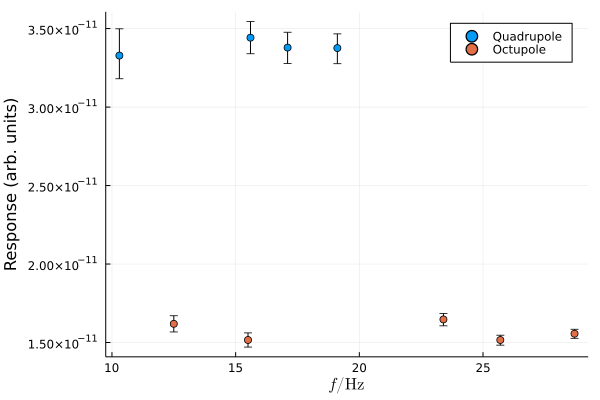

In [6]:
function plot_data(df, label; kwargs...)
    scatter!(df.freq, df.response; yerr=(df.sigma_lower, df.sigma_upper), label=label, kwargs...)
    xlabel!(L"f / \mathrm{Hz}")
    ylabel!("Response (arb. units)")
end
plot()
plot_data(quad_data, "Quadrupole")
plot_data(oct_data, "Octupole")

Looking at the above plot, it certainly seems reasonable enough to ignore the asymmetry in the measurement uncertainty.  It also seems reasonable that there is one "quadrupole" and one "octupole" forcing response at all frequencies (i.e. that the measurements are all "consistent"---we will spend a long time discussing what that means in this course!---with each other).  You may remember formulas from your physics labs for combining such measurements.

If you don't, here they are: for a set of measurements $\{x_i \mid i = 1, \ldots, N \}$ with associated uncertainty $\{\sigma_i \mid i = 1, \ldots, N\}$ (here each $\sigma_i$ is assumed to be the square root of the measurement variance) of the same "true" quantity $x$, the "best" estimate of $x$, $\hat{x}$ is 

$$
  \hat{x} = \frac{\sum_i w_i x_i}{\sum_i w_i},
$$ (weighted_mean)

and the variance of the estimator is

$$
\DeclareMathOperator{\var}{var}
\var \hat{x} = \left( \sum_i w_i \right)^{-1}
$$ (variance_weighted_mean)

where 

$$
w_i = \frac{1}{\sigma_i^2}
$$ (weighted_mean_weights)

This function implements these formulas:

In [7]:
function mean_response_and_uncertainty(df)
    sigmas = (df.sigma_upper .+ df.sigma_lower) ./ 2
    wts = 1 ./ (sigmas.*sigmas)
    mr = (df.response' * wts) / sum(wts)
    mr_uncert = sqrt(1/sum(wts))
    (mr, mr_uncert)
end

mean_response_and_uncertainty (generic function with 1 method)

and applying them to our data sets yields:

In [8]:
((qr, qs), (or, os)) = mean_response_and_uncertainty(quad_data), mean_response_and_uncertainty(oct_data)

((3.3895423514377936e-11, 5.374742788398296e-13), (1.5620160113070848e-11, 1.6411225320059946e-13))

Or, graphically:

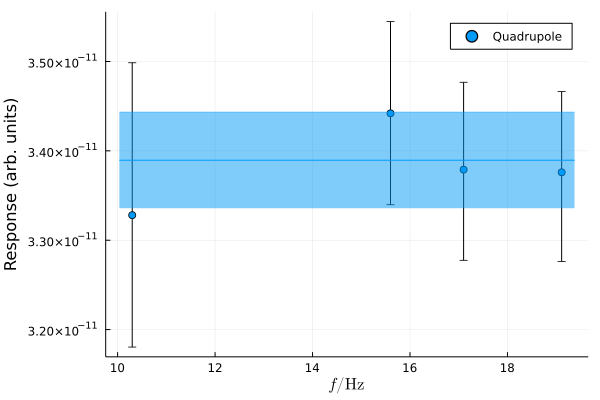

In [9]:
function plot_bands(r, s; color=1, alpha=0.5, kwargs...)
    x0, x1 = xlims()
    plot!([x0, x1], [r, r], color=color, label=nothing)
    plot!([x0, x1], [r+s, r+s]; fillrange=[r-s, r-s], color=color, alpha=alpha, kwargs...)
end

plot()
plot_data(quad_data, "Quadrupole")
plot_bands(qr, qs, color=1, label=nothing)

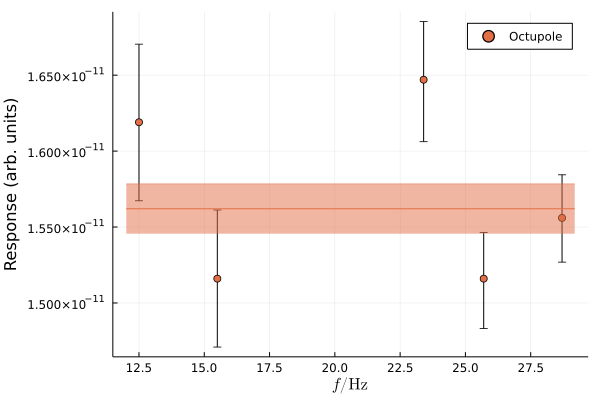

In [10]:
plot()
plot_data(oct_data, "Octupole", color=2)
plot_bands(or, os, color=2, label=nothing)

But where do these formulas come from?  What are the assumptions behind them?

If we imagine that:

* There is a single, true, response value $r$.
* Each measurement of this value suffers from independent "noise" which induces a Gaussian-distributed measured value, $x_i$, that is unbaised (mean $r$) and s.d. $\sigma_i$.

then we can write down the "joint probability distribution" over the unknown $r$ and any measurement values that is 

$$
  \pi \left( \left\{ x_i \right\} , r \right) = p\left( \left\{ x_i \right\} \mid r \right) p\left( r \right)
$$ (joint_gaussian_bayes)

(This is Bayes theorem about factoring a joint probability into a product of a conditional and marginal probability.  Here $p\left( \left\{ x_i \right\} \mid r \right)$ is the *conditional* probability of making the $x_i$ measurements given a particular value of $r$, sometimes called the "likelihood" function for $r$; $p(r)$ is a distribution that reflects our beliefs about the reasonable values of $r$ before the measurement or the possible population of $r$ values over all experiments, sometimes called the "prior.")

The first term in {eq}`joint_gaussian_bayes` becomes a product (independence assumption) of Gaussians (Gaussian-distributed assumption):

$$
p\left( \left\{ x_i \right\} \mid r \right) = \prod_i \frac{1}{\sqrt{2\pi \sigma_i^2}} \exp\left( - \frac{\left( x_i - r \right)^2}{2 \sigma_i^2} \right)
$$ (gaussian_likelihood)

We can use Bayes' theorem to "slice" the joint distribution the "other" way:

$$
\pi \left(\left\{ x_i \right\}, r \right) = p\left( r \mid \left\{ x_i \right\} \right) p\left( \left\{ x_i \right\} \right)
$$ (gaussian_posterior)

Once we have the measurement data $\left\{ x_i \right\}$, this form gives us (up to an annoying constant, $p\left( \left\{ x_i \right\} \right)$, that we will spend some time on later in the course) a "posterior" distribution over $r$ reflecting our knowledge of $r$ given the measurements we have made.  Equating Eq. {eq}`joint_gaussian_bayes` and Eq. {eq}`gaussian_posterior`, and using the form of the likelihood in Eq. {eq}`gaussian_likelihood`, and assuming that whatever distribution we use for $p(r)$ will be much broader than the product of the likelihood functions (this is equivalent to saying that our measurement is *informative*) we have 

$$
p\left( r \mid \left\{ x_i \right\} \right) \propto \exp\left( -\frac{\left( r - \mu_r \right)^2}{2 \sigma_r^2} \right),
$$ (posterior_weights)

where (check the algebra!)

$$
\mu_r = \hat{r} = \frac{\sum_i w_i x_i}{\sum_i w_i}
$$ (weighted_mean_posterior_mean)

and

$$
\sigma_r^2 = \left( \sum_i w_i \right)^{-1}
$$

with

$$
w_i = \frac{1}{\sigma_i^2}.
$$

So, we see that the "standard" formulas for combining uncertain measurements correspond to computing the mean and s.d. of the posterior distribution on the single, true value $r$ given the measurements.

## Model Extensions and Checking

A striking feature of the plots above is that it seems that the uncertainty reported with the measurements is not a good match to the actual scatter about the inferred value of $r$.  In the quadrupolar measurements, the measured responses are "too close" to the truth relative to their errorbars; and the measured responses for the octupolar measurements seem like they could be too far from the truth.

One reasonable extension to the model above could be to introduce a "fudge factor" or "scale factor" that re-scales the reported uncertainties to match the scatter in the data.  This model would trust the *relative* but not *absolute* errorbar sizes; such a fudge-factor is commonly used in photometry, for example.  We will denote the scale factor by $\nu$.

The likelihood function in this case would be modified to 

$$
p\left( \left\{ x_i \right\} \mid r, \nu \right) = \prod_i \frac{1}{\sqrt{2\pi \nu^2 \sigma_i^2}} \exp\left( - \frac{\left( x_i - r \right)^2}{2 \nu^2 \sigma_i^2} \right)
$$ (gaussian_likelihood_errorbar_scaling)

We will use the [`Turing.jl`](https://turing.ml/stable/) {cite}`Tarek2020` package to implement this model and to draw samples from the posterior over the true response and scale factor given the data, $p\left( r, \nu \mid \left\{ x_i \right\} \right)$ (analagous to Eq. {eq}`gaussian_posterior`, but incorporating our extra parameter).  This is worth elaborating on a bit.  Above, we were considering the *function* $p\left( r \mid \left\{ x_i \right\} \right)$ that represented the posterior probability distribution function for $r$ given our observations.  We found that the *function* takes a Gaussian form, with a given mean and standard deviation.  

In general, however, while we may be able to compute arbitrary *values* (or, as above, values *up to a constant factor*) of the posterior density using a computer program, the density won't have a simple functional form that is useful to us.  It may be high dimensional, too (in this case we have only two parameters, but already the dimension is higher than the simpler model above with one parameter); in high dimensions it is cumbersome to work with the functional form of the posterior even if it is represented by simple functions.  In such cases it can be more convenient to work with *samples* drawn from the posterior probability distribution.  Such samples can be used to approximate integrals of the posterior: an integral of some function $f$ over the posterior density $p$ can be approximated by 

$$
\int \mathrm{d} x f(x) p(x) = \left\langle f(x) \right\rangle_{p} \simeq \frac{1}{N} \sum_j f\left( x_j \right)
$$

where $N$ is the number of samples $x_j \sim p(x)$ we have available.  This formula works in any number of dimensions (we will study its error encapsulated in "$\simeq$" carefully later in the term).  

The fact that samples can stand in for the posterior denisty itself is even more magical than it might appear at first; it has to do with the sorts of questions we like to ask using the posterior.  These tend to be "low dimensional" questions even if the posterior itself is high-dimensional.  Consder, for example, a posterior that is uniform on `(-1, 1)` in 100 dimensions: $U(-1, 1)^{100}$.  To even have one sample with each possible sign of each component represented in a set of samples would require $2^{100} \simeq 10^{30}$ samples!  But even a few tens of samples is sufficient to discover, for example, that $\left\langle \vec{x} \right\rangle = \vec{0}$ when $\vec{x} \sim U\left( -1, 1 \right)^{100}$ to quite good accuracy.

There are various algorithms for drawing samples from an arbitrary distribution that we will be discussing in the course; the `Turing` library implements several of them.  Here we will be using "No U-Turn Sampling" {cite}`Hoffman2011` which is an automatically-tuned variant of the Hamiltonian Monte Carlo MCMC method {cite}`Neal2011`.  More on these sorts of algorithms later.  

Back to our specific example: the `Turing` library needs from us a description of the joint density on $\left\{ x_i \right\}$ and $\left( r, \nu \right)$, and then the values of the $x_i$.  It then can draw samples of $r$ and $\nu$ from the conditional posterior density (the $x_i$ are fixed).

One of the strengths of `Turing` and similar libraries like `numpyro`, `pymc3`, `stan`, ..., is that we don't have to write out the posterior function explicitly (as we have done above, in Eq. {eq}`gaussian_likelihood_errorbar_scaling`); instead we can specify that certain variables follow certain distributions, and `Turing` will build up the right density for us.  It can even handle constraints like the fact that $0 < \nu < \infty$ elegantly (it makes no sense for us to scale the quoted uncertainties by a negative number).

Of course, if we *do* want to write out our functions that go into the posterior distribution explicitly, there is a way to do that, too.  Stay tuned!

The code for the `Turing` implementation of the scaled-errorbar model is in the next cell.  Models are implemented as a `@model` macro (to introduce some extra syntax like the `~` operator: writing `x ~ Y(z)` means that the variable `x` is distributed according to the distribution `Y` which can have parameters `z`) that closely follows the definition syntax for a function.  The arguments to the "function" are the data and whatever parameters on which the model is conditioned; here the measured responses and their uncertainties.  Within the function, we define distributions for parameters (i.e. priors, see Eq. {eq}`gaussian_posterior`) and also distributions for data (likelihood functions) that can depend on parameters and other data.  When `Turing` sees a "new" variable in a `~` statement (i.e. a variable that is not a function argument), then it treats it as the definition of a new parameter to be sampled over; when it sees an already-defined variable (i.e. a function argument) in a `~` statement, then it assumes that variable should be *conditioned on* and assumes the value that is passed to the model constructor when the model is instantiated; see comments in the model below:

In [11]:
# The model depends on the measured responses and their uncertainties; these are the quantities "to the right of the bar" above
@model function scaled_errorbar(responses, sigmas)
    # It is inconvenient to work with quantities that are O(1e-11), so we define these "unit-scale" parameters from which the actual parameters are derived.
    r_unit ~ Normal(0, 10) # r_unit follows a Gaussian distribution with mean zero and width 10
    nu ~ LogNormal(log(1), 1) # the scale factor follows a log-normal distribution with mean (of the log) 0 and s.d. (of the log) 1.
    
    # If r_unit ~ N(0,10), then r ~ N(mean(response), 10*std(response)), which is a broad and uninformative prior for the parameter r
    r = mean(responses) + std(responses)*r_unit
    
    # The likelihood function: we construct an array of Normal distributions with mean r and standard deviation nu*sigma_i;
    # the array of measurements is assumed drawn from this array of distributions.
    responses ~ arraydist([Normal(r, nu*s) for s in sigmas])
    
    # Parameters like r_unit and nu will automatically be captured in the fitting of the model; but additional "generated" quantities need to be explicitly 
    # returned.  Here `r` is such a "generated" quantity, so we return it in a "named tuple"
    return (r=r, )
end

scaled_errorbar (generic function with 1 method)

Now we construct a model instance from the quadrupolar data, draw samples from it using 1000 steps of the NUTS algorithm (again, stay tuned!), generate the quantities like $r$ that are defined in terms of more basic parameters, and display the MCMC "trace."  Unfortunately, at this time `Turing` does not treat the "generated" quantities on the same footing as the sampled parameters; so I have written a little utility function in the `Astrostatistics688` library that appends the generated quantities into the trace *as if* they were sampled parameters: `append_generated_quantities`.

In [12]:
scaled_quad_model = scaled_errorbar(quad_data.response, 0.5 .* (quad_data.sigma_lower .+ quad_data.sigma_upper))
scaled_quad_trace = sample(scaled_quad_model, NUTS(), 1000)
scaled_quad_genq = with_logger(NullLogger()) do # Sometimes this throws a lot of warnings that we don't care about.
    generated_quantities(scaled_quad_model, scaled_quad_trace)
end
scaled_quad_trace = append_generated_quantities(scaled_quad_trace, scaled_quad_genq)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = nu, r_unit, r
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

      r_unit    0.1848    0.6805     0.0215    0.0262   460.7023    1.0068
          nu    0.5830    0.3024     0.0096    0.0176   254.7408    0.9991
           r    0.0000    0.0000     0.0000    0.0000   460.7023    1.0068

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      r_unit   -1.1717   -0.2107    0.1758    0.5655    1.5847
          nu    0.2478    0.3897   

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/tfR90/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/tfR90/src/chains.jl:364


The `StatsPlots` package knows how to plot MCMC traces:

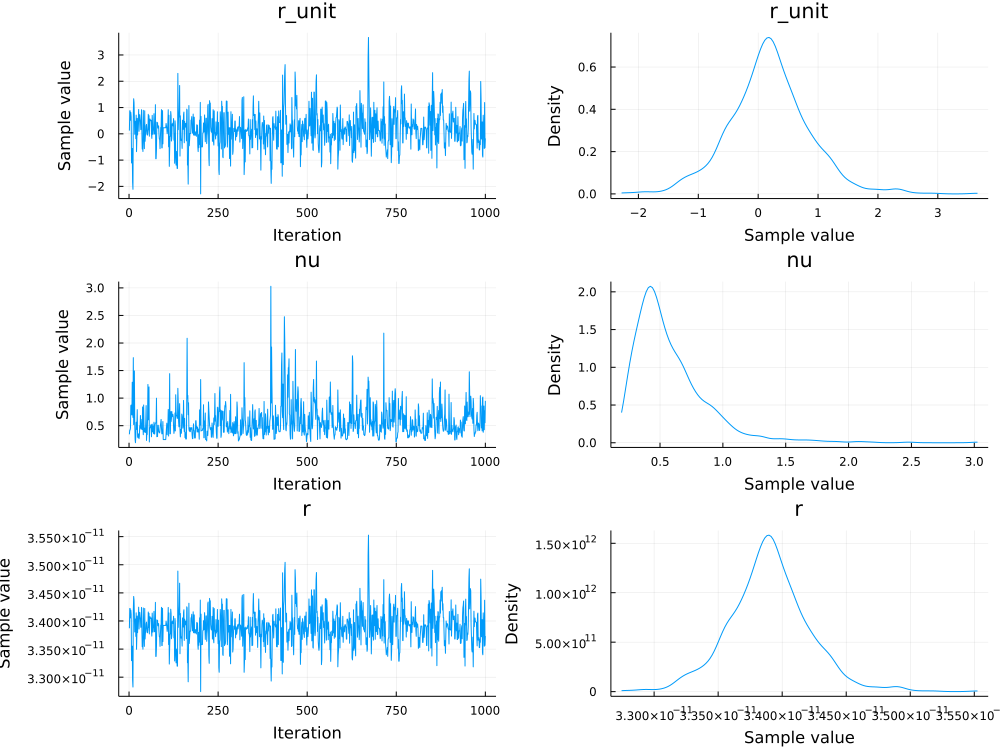

In [13]:
plot(scaled_quad_trace)

What we see above in the left-hand column is the samples in each parameter that were drawn as a function of the iteration number.  We will talk in great detail about the NUTS/HMC algorithm and MCMC in general later in the course; for now, just know that the algorithm takes the "current" sample and evolves it according to a dynamical system to generate the "next" sample.  So there will be some degree of correlation from sample-to-sample; we want that to be as small as possible, so that the samples "mix" into the full posterior distribution (sometimes called the "target distribution") quickly.  You can see in these plots that successive samples appear pretty random, so the mixing looks good.  This is also captured by the `ess` column in the textual output above, which gives (very roughly) the effective number of *independent* draws from the posterior distribution by estimating the sample-to-sample correlation.

What we see in the right-hand column is an estimate of the 1D density of the samples in each parameter; these are the "marginal" distributions of $r$ (marginalized over all possible values of $\nu$) and $\nu$ (marginalized over all possible values of $r$).

It is particularly interesting to look at the posterior density (i.e. our uncertainty about) the $\nu$ parameter: it does not peak at $\nu = 1$ (the point at which the quoted errorbars correctly represent the scatter in the observations).  In fact, $\nu = 1$ lives quite far in the tail---only 7.1% of the posterior samples have $\nu > 1$.

It looks like our guess that the uncertainties were over-estimated is correct!

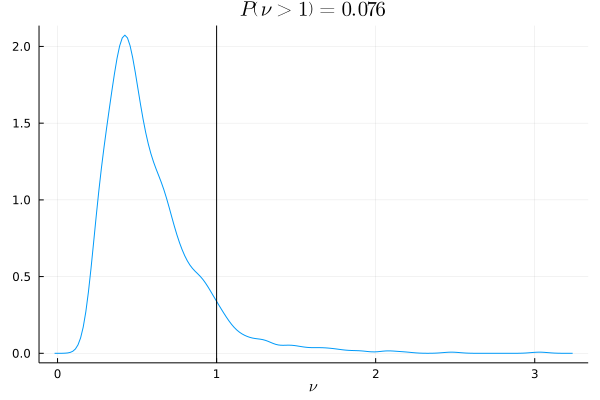

In [14]:
p_nu_gt_1 = sum(scaled_quad_trace[:nu] .> 1) / length(scaled_quad_trace)
@df scaled_quad_trace density(:nu, xlabel=L"\nu", label=nothing)
vline!([1], color=:black, label=nothing)
title!(@sprintf("\$P\\left( \\nu > 1 \\right) = %.3f\$", p_nu_gt_1))

Together with the re-scaled observational uncertainties, we can re-estimate the underlying response value; our estimate will become better, because the scale factor $\nu < 1$ so the errorbars that the model uses will be smaller than the quoted uncertainty.  The central estimate barely changes, though, because the *relative* contribution of each data point remains the same (mathematically: the factor $\nu$ cancels in the formula for $\mu_r$ in Eq. {eq}`weighted_mean` or {eq}`weighted_mean_posterior_mean`).

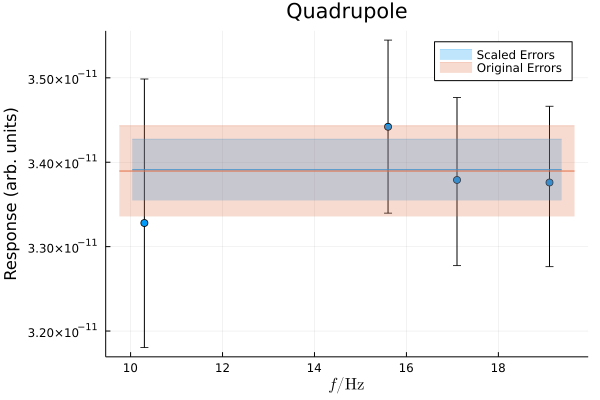

In [17]:
plot()
plot_data(quad_data, nothing)
plot_bands(mean(scaled_quad_trace[:r]), std(scaled_quad_trace[:r]), color=1, label="Scaled Errors", alpha=0.25)
plot_bands(qr, qs, color=2, label="Original Errors", alpha=0.25)
title!("Quadrupole")

Now we can do the same thing for the octupole data:

In [18]:
scaled_oct_model = scaled_errorbar(oct_data.response, 0.5 .* (oct_data.sigma_lower .+ oct_data.sigma_upper))
scaled_oct_trace = sample(scaled_oct_model, NUTS(), 1000)
scaled_oct_genq = with_logger(NullLogger()) do # Sometimes this throws a lot of warnings that we don't care about.
    generated_quantities(scaled_oct_model, scaled_oct_trace)
end
scaled_oct_trace = append_generated_quantities(scaled_oct_trace, scaled_oct_genq)

┌ Info: Found initial step size
│   ϵ = 0.20078125000000002
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188


Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = nu, r_unit, r
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

      r_unit   -0.1313    0.4620     0.0146    0.0288   321.1306    1.0003
          nu    1.6619    0.6181     0.0195    0.0325   371.8679    0.9990
           r    0.0000    0.0000     0.0000    0.0000   321.1306    1.0003

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      r_unit   -1.0735   -0.4081   -0.1395    0.1483    0.8117
          nu    0.8802    1.2458   

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/tfR90/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /Users/wfarr/.julia/packages/MCMCChains/tfR90/src/chains.jl:364


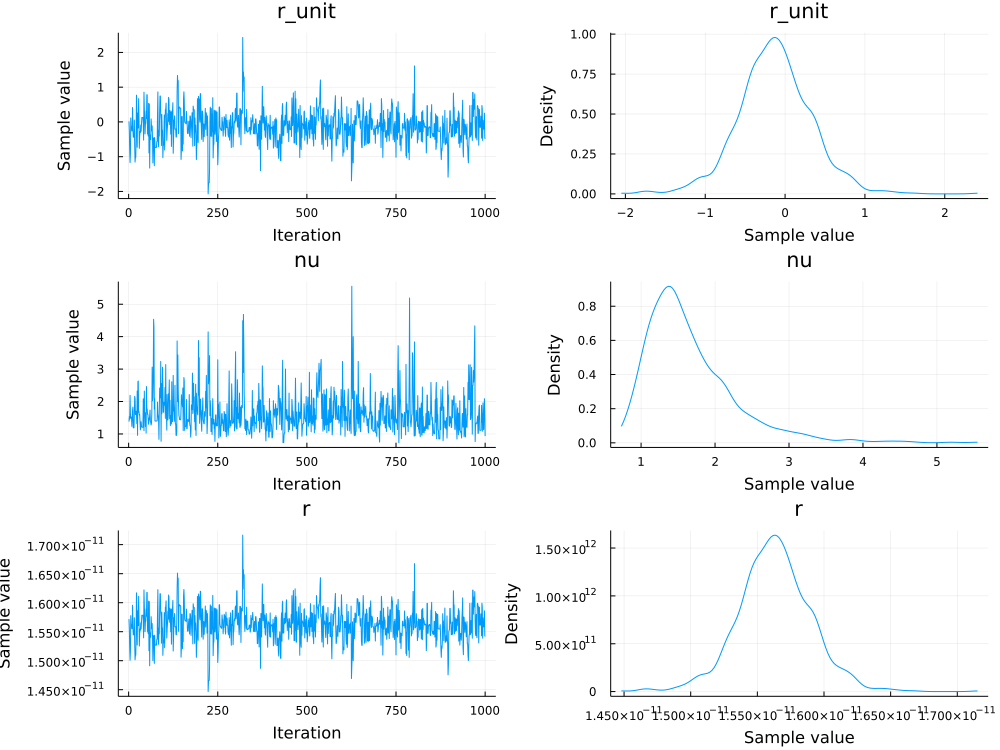

In [19]:
plot(scaled_oct_trace)

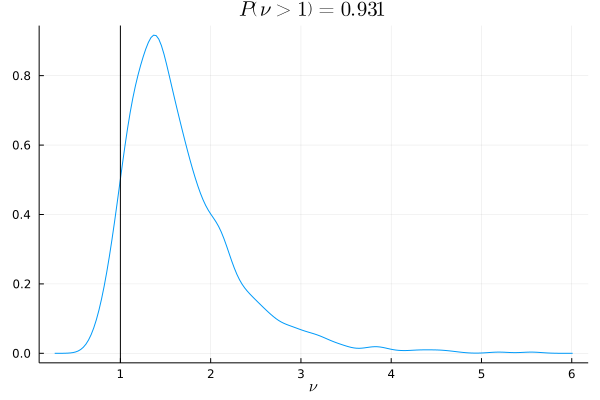

In [20]:
p_nu_gt_1 = sum(scaled_oct_trace[:nu] .> 1) / length(scaled_oct_trace)
@df scaled_oct_trace density(:nu, xlabel=L"\nu", label=nothing)
vline!([1], color=:black, label=nothing)
title!(@sprintf("\$P\\left( \\nu > 1 \\right) = %.3f\$", p_nu_gt_1))

It looks like our supposition that these errorbars were *underestimated* is correct!  Re-computing our estimate for $r$, we see that the uncertainty has *grown*:

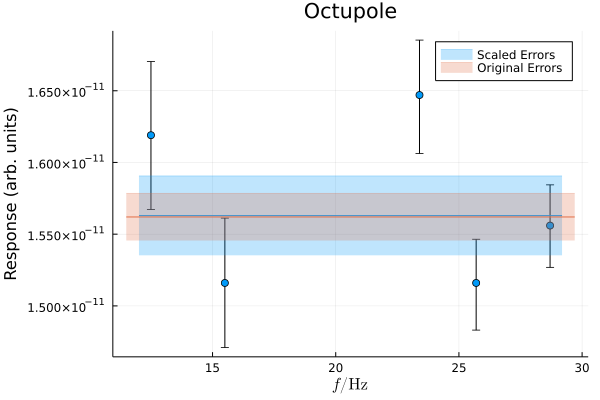

In [21]:
plot()
plot_data(oct_data, nothing)
plot_bands(mean(scaled_oct_trace[:r]), std(scaled_oct_trace[:r]), color=1, label="Scaled Errors", alpha=0.25)
plot_bands(or, os, color=2, label="Original Errors", alpha=0.25)
title!("Octupole")

## If That Was Model "Expansion," Let's Try Model "Explosion"

At the risk of flogging a dead horse, let's try one more model for these data.  In the last model, we *assumed* that the response value was constant across measurements (i.e. in frequency), and used this assumption to re-scale the quoted measurement uncertainty to match the actual scatter of the observations around the fixed response value.

What if, instead, we imagine that each experiment measured 

In [77]:
@model function normal_hierarchical(responses, sigmas)
    mu_r_unit ~ Normal(0,1)
    sigma_r_unit ~ truncated(Normal(0,1), 0, Inf)
    r_unit ~ filldist(Normal(0,1), length(responses))
    
    mu_r = mean(responses) + std(responses)*mu_r_unit
    sigma_r = std(responses)*sigma_r_unit
    r = mu_r .+ sigma_r.*r_unit
    
    responses ~ arraydist([Normal(rr, s) for (rr,s) in zip(r, sigmas)])
    
    (mu_r=mu_r, sigma_r=sigma_r, r=r)
end

normal_hierarchical (generic function with 1 method)

In [78]:
nhq = normal_hierarchical(quad_data.response, 0.5 .* (quad_data.sigma_lower .+ quad_data.sigma_upper))
nht = sample(nhq, NUTS(), 1000)
nhg = with_logger(NullLogger()) do 
    generated_quantities(nhq, nht)
end

nht

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188


Chains MCMC chain (1000×18×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 3.26 seconds
Compute duration  = 3.26 seconds
parameters        = sigma_r_unit, mu_r_unit, r_unit[3], r_unit[2], r_unit[1], r_unit[4]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat  ⋯
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64  ⋯

     mu_r_unit    0.0547    0.7332     0.0232    0.0230    946.6228    1.0000  ⋯
  sigma_r_unit    0.6681    0.5061     0.0160    0.0234    764.7821    0.9998  ⋯
     r_unit[1]   -0.0695    0.9590     0.0303    0.0296   1142.4989    0.9990  ⋯
     r_unit[2]    0.1227    0.9432     0.0298    0.0271   1068.9487    0.9998  ⋯
     r_

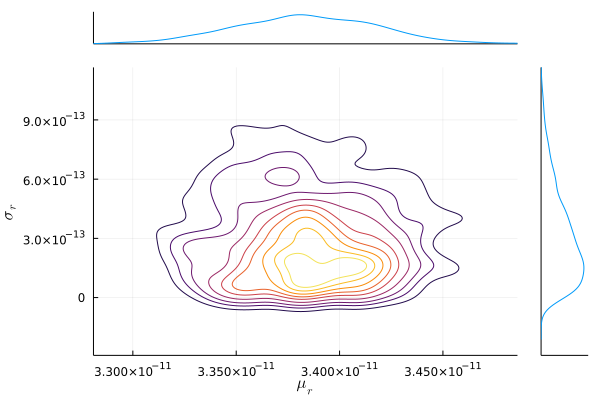

In [80]:
marginalkde(vec([x.mu_r for x in nhg]), vec([x.sigma_r for x in nhg]), xlabel=L"\mu_r", ylabel=L"\sigma_r")

In [82]:
nho = normal_hierarchical(oct_data.response, 0.5 .* (oct_data.sigma_lower .+ oct_data.sigma_upper))
nht = sample(nho, NUTS(), 1000)
nhg = with_logger(NullLogger()) do 
    generated_quantities(nho, nht)
end

nht

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Ysmbf/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×19×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.27 seconds
Compute duration  = 0.27 seconds
parameters        = sigma_r_unit, mu_r_unit, r_unit[3], r_unit[2], r_unit[1], r_unit[4], r_unit[5]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse        ess      rhat   ⋯
        Symbol   Float64   Float64    Float64   Float64    Float64   Float64   ⋯

     mu_r_unit   -0.0757    0.4044     0.0128    0.0167   418.1793    1.0002   ⋯
  sigma_r_unit    0.6898    0.4226     0.0134    0.0289   358.6332    0.9994   ⋯
     r_unit[1]    0.3608    0.8478     0.0268    0.0393   802.9353    0.9996   ⋯
     r_unit[2]   -0.4208    0.7887     0.0249    0.0254   644.5201    0.9997 

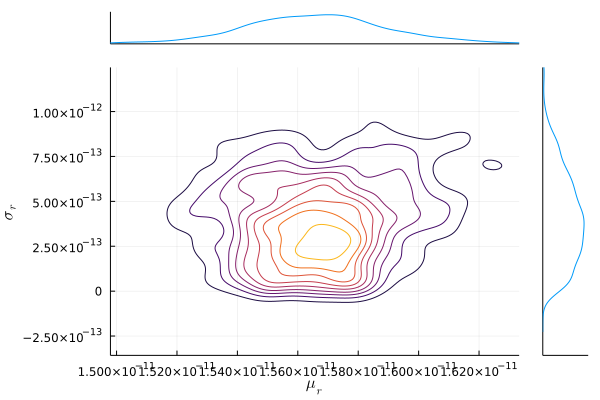

In [83]:
marginalkde(vec([x.mu_r for x in nhg]), vec([x.sigma_r for x in nhg]), xlabel=L"\mu_r", ylabel=L"\sigma_r")